In [1]:
import os
import cv2
import numpy as np

# Function to load images and labels
def load_images_and_labels(folder_path):
    images = []
    labels = []
    
    for category in ["Positive", "Negative"]:
        class_label = 1 if category == "Positive" else 0
        path = os.path.join(folder_path, category)
        
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            
            
            if img_name.startswith('.'):
                continue  
            
            img = cv2.imread(img_path)
            
            #  Skip invalid images
            if img is None:
                print(f"⚠ Skipping non-image file: {img_path}")
                continue
            
            img = cv2.resize(img, (227, 227))  # Resize
            img = img / 255.0  # Normalize pixel values
            images.append(img)
            labels.append(class_label)
    
    return np.array(images), np.array(labels)

# Load dataset again
X, y = load_images_and_labels("images/")

# Print confirmation
print(f" Successfully loaded {len(X)} images.")


 Successfully loaded 2000 images.


In [2]:
from tensorflow.keras.models import load_model
model_vgg = load_model("crack_detection_model.h5")
model_unet = load_model("unet_crack_segmentation.h5")  


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Define dataset path
dataset_path = "images/"
img_size = (227, 227)  # Resize images to 227x227 pixels

# Function to load images and labels
def load_images_and_labels(folder_path):
    images = []
    labels = []
    
    for category in ["Positive", "Negative"]:
        class_label = 1 if category == "Positive" else 0
        path = os.path.join(folder_path, category)

        # Ensure directory exists
        if not os.path.exists(path):
            print(f"⚠ Warning: Directory {path} does not exist!")
            continue
        
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            
            #  Skip hidden/system files
            if img_name.startswith('.'):
                continue
            
            #  Read image
            img = cv2.imread(img_path)

            #  Skip invalid files
            if img is None:
                print(f"⚠ Skipping invalid image file: {img_path}")
                continue
            
            #  Ensure images are in RGB format
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            
            #  Resize image
            img = cv2.resize(img, img_size)
            
            #  Normalize pixel values
            img = img / 255.0  
            
            images.append(img)
            labels.append(class_label)
    
    return np.array(images), np.array(labels)


In [4]:
# Load dataset
X, y = load_images_and_labels(dataset_path)

# Check if dataset is loaded properly
if len(X) == 0:
    raise ValueError("No valid images found! Check dataset path and structure.")

# Convert labels to categorical (for classification)
y_categorical = to_categorical(y, num_classes=2)

# Split into Training (70%), Validation (15%), and Test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset details
print(f" Dataset Loaded: {X.shape[0]} images")
print(f" Training set: {X_train.shape[0]} images")
print(f" Validation set: {X_val.shape[0]} images")
print(f" Test set: {X_test.shape[0]} images")


 Dataset Loaded: 2000 images
 Training set: 1400 images
 Validation set: 300 images
 Test set: 300 images


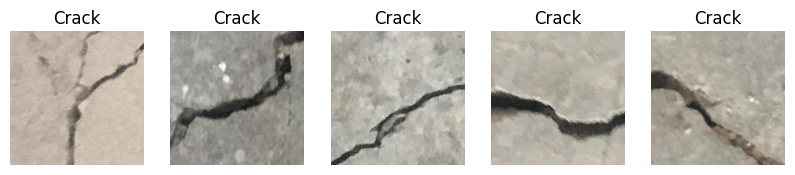

In [5]:
# Show some sample images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[i])
    plt.title("Crack" if y[i] == 1 else "No Crack")  
    plt.axis("off")
plt.show()

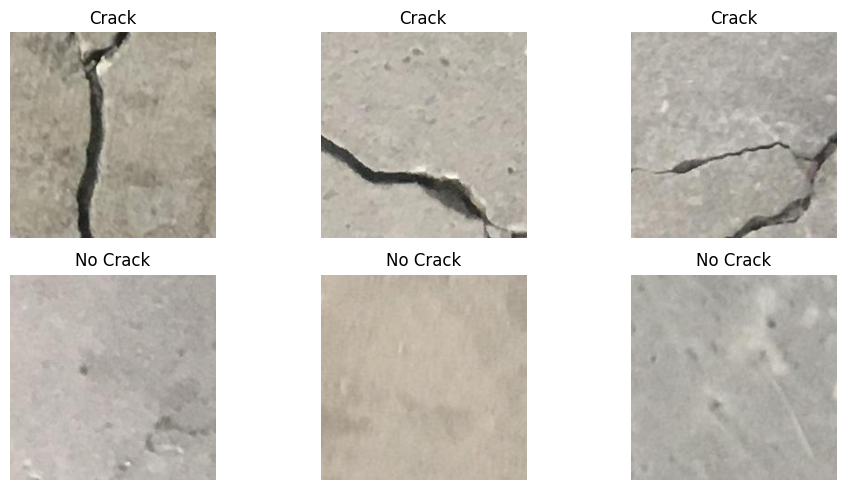

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Find indices of Crack (1) and No Crack (0) images
crack_indices = np.where(y == 1)[0]  # Indices where label = 1 (Crack)
no_crack_indices = np.where(y == 0)[0]  # Indices where label = 0 (No Crack)

# Select 3 Crack images and 3 No Crack images 
num_samples = 3
selected_crack = np.random.choice(crack_indices, num_samples, replace=False)
selected_no_crack = np.random.choice(no_crack_indices, num_samples, replace=False)

# Combine selected indices
selected_indices = np.concatenate([selected_crack, selected_no_crack])

# Plot the selected images
plt.figure(figsize=(10, 5))
for i, idx in enumerate(selected_indices):
    plt.subplot(2, 3, i+1)  # 2 rows, 3 columns
    plt.imshow(X[idx])
    plt.title("Crack" if y[idx] == 1 else "No Crack")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pretrained VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(227, 227, 3))
base_model.trainable = False  # Freeze layers

# Build the classification model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),  # Prevent overfitting
    Dense(2, activation="softmax")  # Binary classification (Crack/No Crack)
])

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    horizontal_flip=True, validation_split=0.2
)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=10, validation_data=(X_val, y_val))

# Save the trained model
model.save("crack_detection_model.h5")


C:\Users\sheyi\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 355s 8s/step - accuracy: 0.7686 - loss: 0.6375 - val_accuracy: 0.9900 - val_loss: 0.0397
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 341s 8s/step - accuracy: 0.9701 - loss: 0.0742 - val_accuracy: 0.9933 - val_loss: 0.0267
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 342s 8s/step - accuracy: 0.9835 - loss: 0.0518 - val_accuracy: 0.9933 - val_loss: 0.0210
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 339s 8s/step - accuracy: 0.9867 - loss: 0.0401 - val_accuracy: 0.9933 - val_loss: 0.0317
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 336s 8s/step - accuracy: 0.9750 - loss: 0.0790 - val_accuracy: 0.9933 - val_loss: 0.0190
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 338s 8s/step - accuracy: 0.9858 - loss: 0.0541 - val_accuracy: 0.9933 - val_loss: 0.0175
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 341s 8s/step - accuracy: 0.9882 - loss: 0.0391 - val_accuracy: 0.9933 - val_loss: 0.0170
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 342s 8s/step - accuracy: 0.9845 - loss: 0.0451 - val_accuracy: 0.9933 - v

In [8]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("crack_detection_model.h5")
print(" Model Loaded Successfully!")


 Model Loaded Successfully!


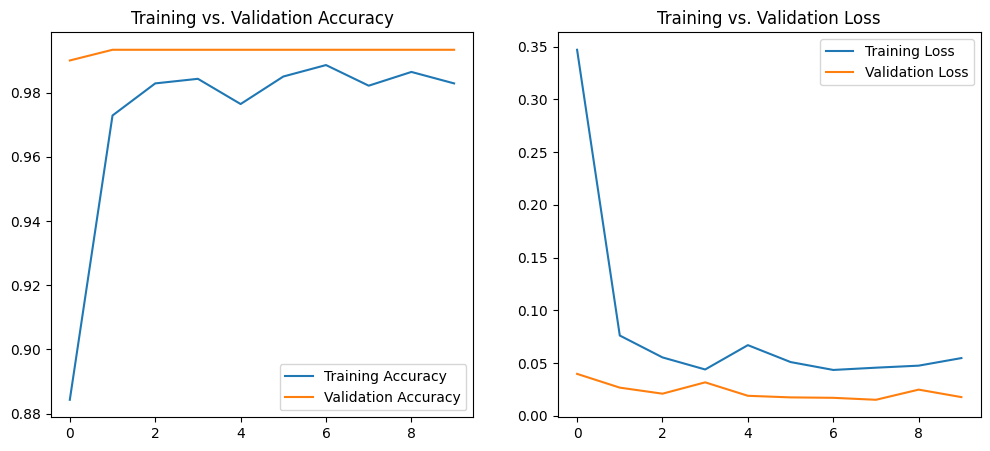

In [9]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs. Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs. Validation Loss')

plt.show()


# Training vs. Validation Accuracy & Loss

## **Graphs**
The two plots illustrate how the model's **accuracy and loss** evolved during training.

---

## **Left Graph: Training vs. Validation Accuracy**
### **What It Shows**
- The **blue line** represents **Training Accuracy**.
- The **orange line** represents **Validation Accuracy**.

### **Key Observations**
**Accuracy increases rapidly** in the first few epochs, reaching ~98-99%.  
 **Training and validation accuracy are very close**, indicating **no major overfitting**.  
 A slight dip towards the end suggests **some variance** but remains stable overall.

 **Conclusion:**  
- The model is **generalizing well**, as the validation accuracy remains close to training accuracy.
- The high accuracy (~99%) indicates **strong performance** on both training and validation data.

---

## **Right Graph: Training vs. Validation Loss**
### **What It Shows**
- The **blue line** represents **Training Loss**.
- The **orange line** represents **Validation Loss**.

### **Key Observations**
 **Training loss drops sharply** in the first epoch, indicating fast learning. 
 **Validation loss remains very low (~0.02),** meaning the model is making **stable predictions**.  
 There is **no noticeable overfitting**, as validation loss does not increase.

 **Conclusion:**  
- **Low and stable validation loss** means the model is **not memorizing training data** (good generalization).  
- **No sudden spikes in validation loss** → No major overfitting or instability.

---

## **Final Assessment**
 The model is **highly accurate (98-99%)** on both training and validation data.  
 The **loss remains very low**, confirming **good generalization 
 No signs of **overfitting** or **underfitting**.  

 **Overall, this is a well-trained model with strong performance!** 


10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step


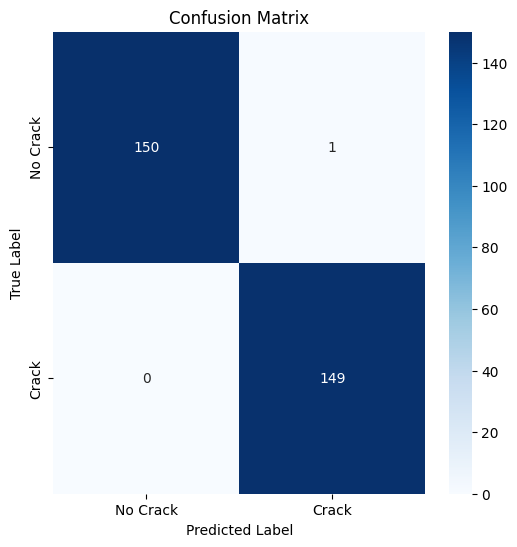

In [10]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Crack", "Crack"], yticklabels=["No Crack", "Crack"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess images
def preprocess_image(image_path):
    img = cv2.imread(image_path)  # Load image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (227, 227))  # Resize to match VGG16 input size
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


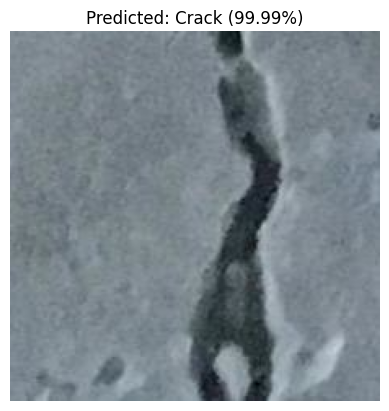

Prediction Probabilities: [[5.665002e-05 9.999434e-01]]
Final Prediction: Crack with 99.99% confidence


In [12]:
test_image_positive = "images/pim1.jpg"  

# Preprocess the image
image = preprocess_image(test_image_positive)
# Make a prediction
prediction = model.predict(image)

# Get class labels
class_names = ["No Crack", "Crack"]
predicted_class = class_names[np.argmax(prediction)]  # Get the class with highest probability
confidence = np.max(prediction)  # Get confidence score

# Display results
plt.imshow(cv2.imread(test_image_positive))
plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}%)")
plt.axis("off")
plt.show()

# Print detailed prediction probabilities
print(f"Prediction Probabilities: {prediction}")
print(f"Final Prediction: {predicted_class} with {confidence*100:.2f}% confidence")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


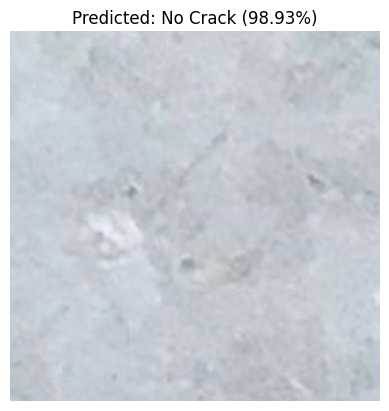

Prediction Probabilities: [[0.9892925  0.01070753]]
Final Prediction: No Crack with 98.93% confidence


In [13]:
# Provide the path to your test image
test_image_negative = "images/neg1.jpg"  

# Preprocess the image
image = preprocess_image(test_image_negative)
# Make a prediction
prediction = model.predict(image)

# Get class labels
class_names = ["No Crack", "Crack"]
predicted_class = class_names[np.argmax(prediction)]  # Get the class with highest probability
confidence = np.max(prediction)  # Get confidence score

# Display results
plt.imshow(cv2.imread(test_image_negative))
plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}%)")
plt.axis("off")
plt.show()

# Print detailed prediction probabilities
print(f"Prediction Probabilities: {prediction}")
print(f"Final Prediction: {predicted_class} with {confidence*100:.2f}% confidence")


 Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


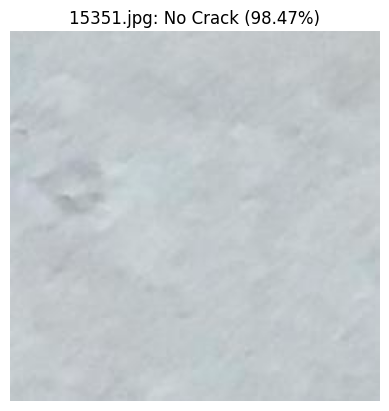

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


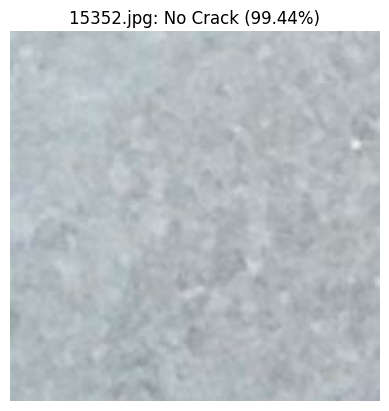

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


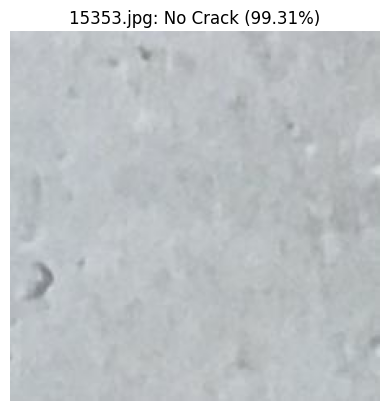

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


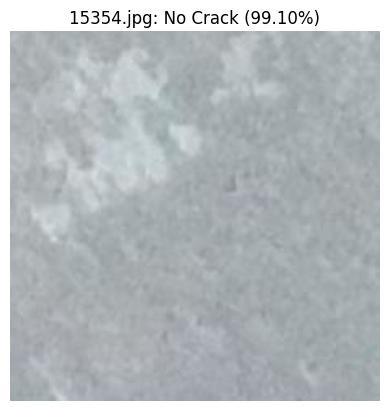

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


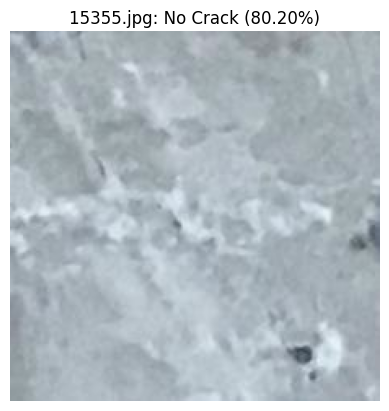

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


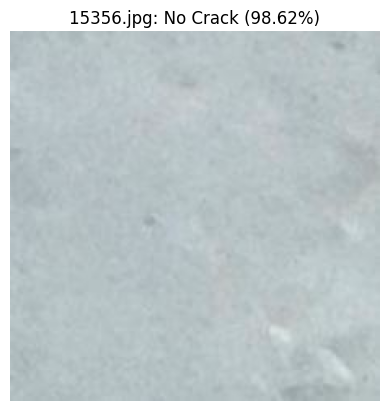

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


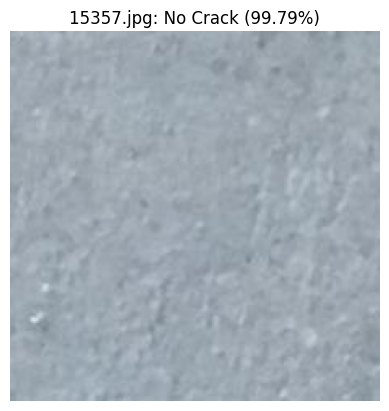

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


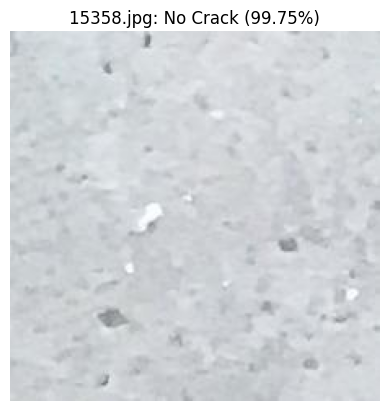

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


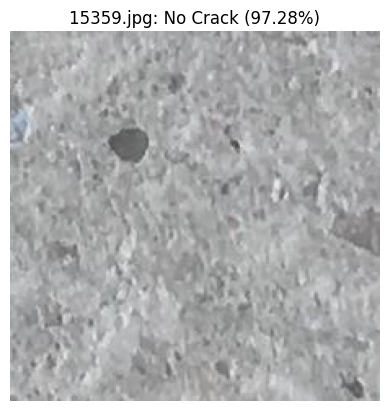

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


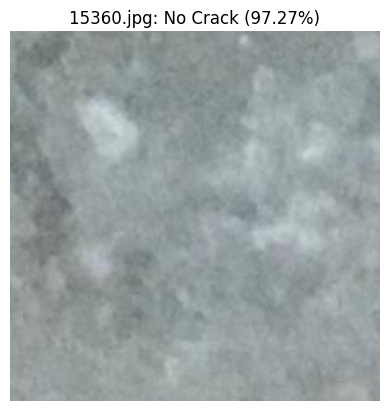

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


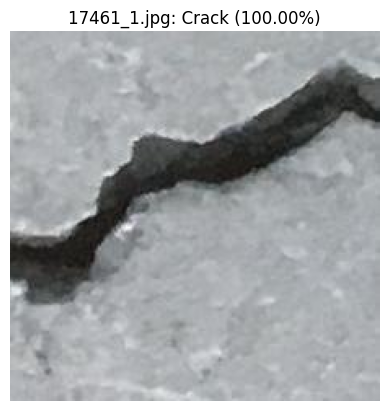

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


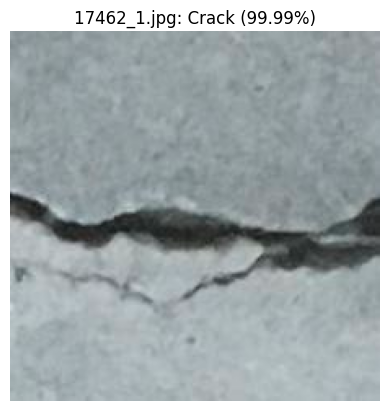

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


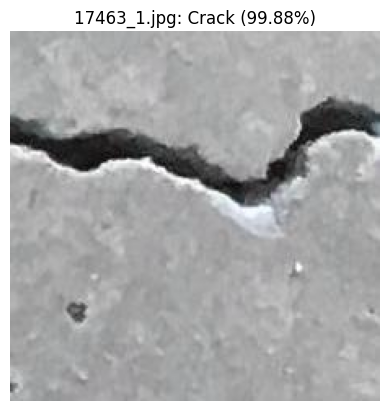

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


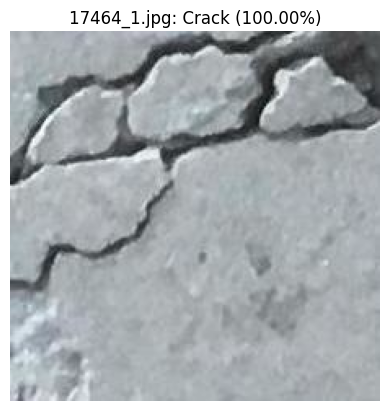

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


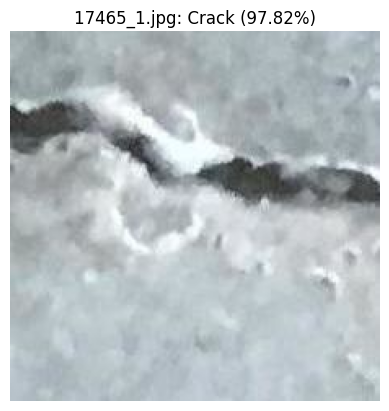

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


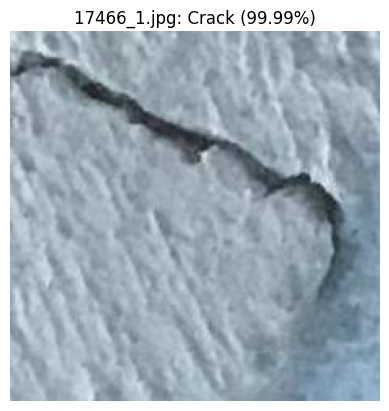

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


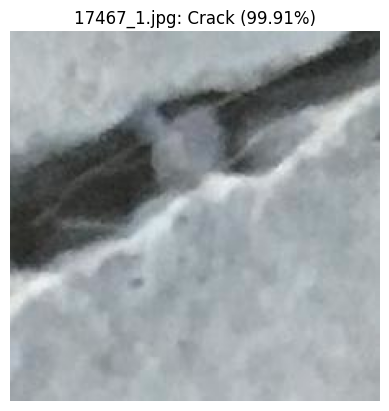

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


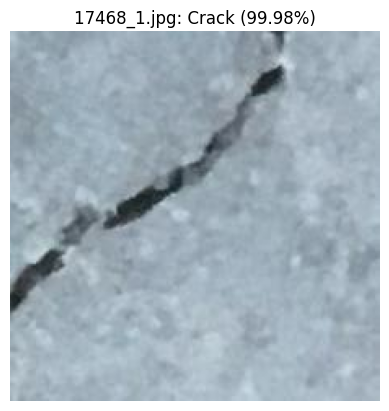

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


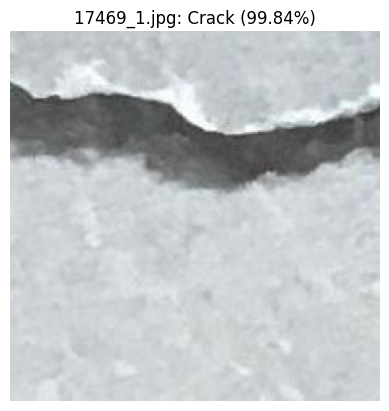

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


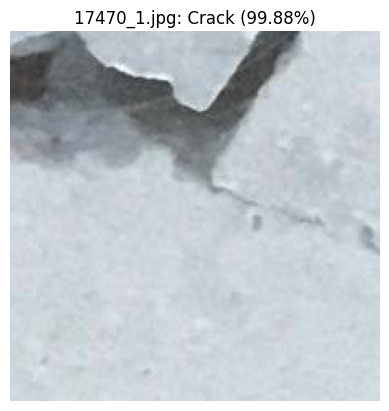

 Batch classification complete! Results saved in 'batch_predictions.txt'


In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load trained model
model = load_model("crack_detection_model.h5")
print(" Model loaded successfully!")

# Define test image folder
test_folder = "images/test_images/"  

# Get all image files in the folder
image_files = [f for f in os.listdir(test_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Function to preprocess images
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f" Warning: Could not read {image_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (227, 227))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Dictionary to store results
results = {}

# Process each image
for img_file in image_files:
    img_path = os.path.join(test_folder, img_file)
    
    # Preprocess image
    processed_img = preprocess_image(img_path)
    if processed_img is None:
        continue  # Skip unreadable images
    
    # Make a prediction
    prediction = model.predict(processed_img)
    
    # Get predicted class and confidence
    class_names = ["No Crack", "Crack"]
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100  # Convert to percentage
    
    # Store results
    results[img_file] = {"Prediction": predicted_class, "Confidence": confidence}
    
    # Display results
    plt.imshow(cv2.imread(img_path))
    plt.title(f"{img_file}: {predicted_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()

# Save results to a text file
with open("batch_predictions.txt", "w") as f:
    for img, res in results.items():
        f.write(f"{img}: {res['Prediction']} ({res['Confidence']:.2f}%)\n")

print(" Batch classification complete! Results saved in 'batch_predictions.txt'")


In [15]:
import os
print("Current working directory:", os.getcwd())


Current working directory: C:\Users\sheyi


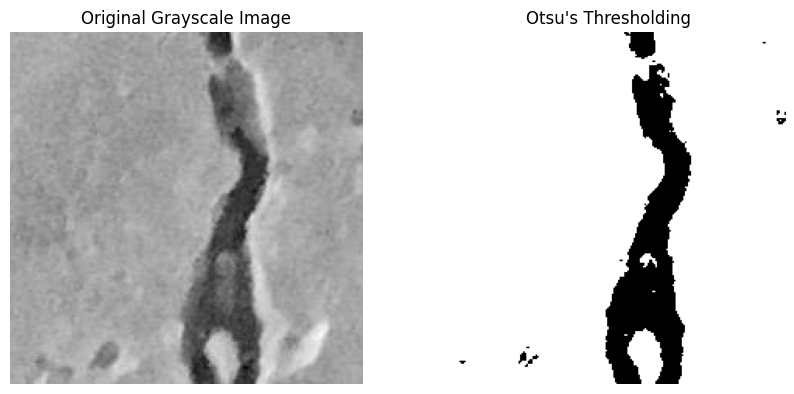

In [17]:
import cv2
import matplotlib.pyplot as plt

# Load image in grayscale
image_path = "images/pim1.jpg"  
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Otsu's Thresholding
_, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Show results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image, cmap="gray")
plt.title("Original Grayscale Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(binary_image, cmap="gray")
plt.title("Otsu's Thresholding")
plt.axis("off")

plt.show()


# SVM + HOG

In [18]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Define image folder paths
base_path = "images/"
categories = ["Negative", "Positive"]  # 0 = No Crack, 1 = Crack

# Parameters
img_size = (128, 128)
hog_features = []
labels = []

# Extract HOG features from each image
for label, category in enumerate(categories):
    folder = os.path.join(base_path, category)
    for filename in os.listdir(folder):
        if filename.endswith(('.jpg', '.png')):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            gray = rgb2gray(img)
            features = hog(gray, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys')
            hog_features.append(features)
            labels.append(label)

X = np.array(hog_features)
y = np.array(labels)

print(f" Extracted HOG features from {len(X)} images.")


 Extracted HOG features from 2000 images.


In [19]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM
svm_clf = SVC(kernel='linear', probability=True)
svm_clf.fit(X_train, y_train)

# Evaluate
y_pred = svm_clf.predict(X_test)
print(" Classification Report:\n", classification_report(y_test, y_pred))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       199
           1       0.97      0.94      0.95       201

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400

 Confusion Matrix:
 [[193   6]
 [ 13 188]]


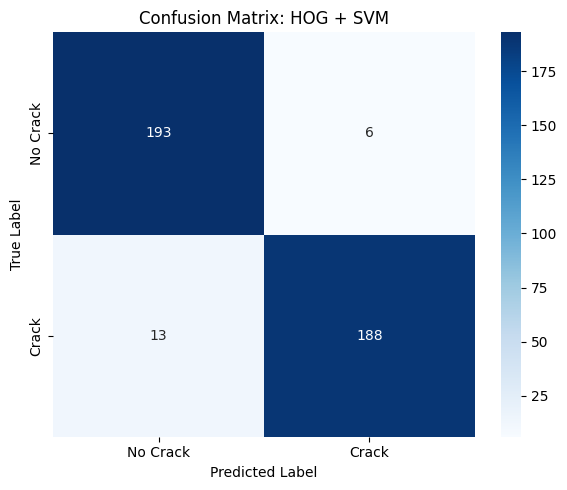

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ["No Crack", "Crack"]

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: HOG + SVM")
plt.tight_layout()

# Save to file
plt.savefig("hog_svm_confusion_matrix.png", dpi=150)
plt.show()


In [22]:
print("HOG+SVM SET:", len(y_test))
print("class dist:", np.bincount(y_test))

HOG+SVM SET: 400
class dist: [199 201]


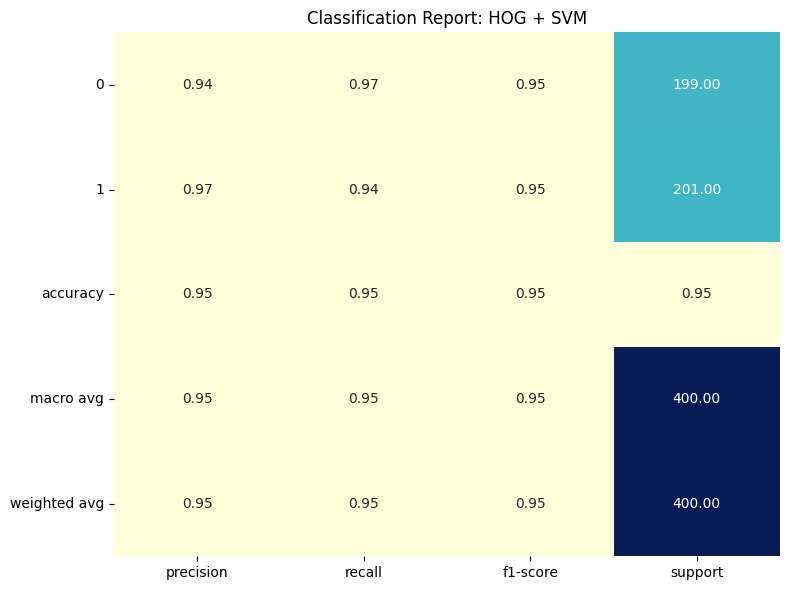

In [23]:
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Generate classification report as a dictionary
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convert to DataFrame and round to 2 decimal places
df = pd.DataFrame(report_dict).transpose().round(2)

# Keep all rows, including accuracy and averages
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".2f", cbar=False)

plt.title("Classification Report: HOG + SVM")
plt.yticks(rotation=0)
plt.tight_layout()

# Save the figure
plt.savefig("hog_svm_classification_report_table.png", dpi=150)
plt.show()


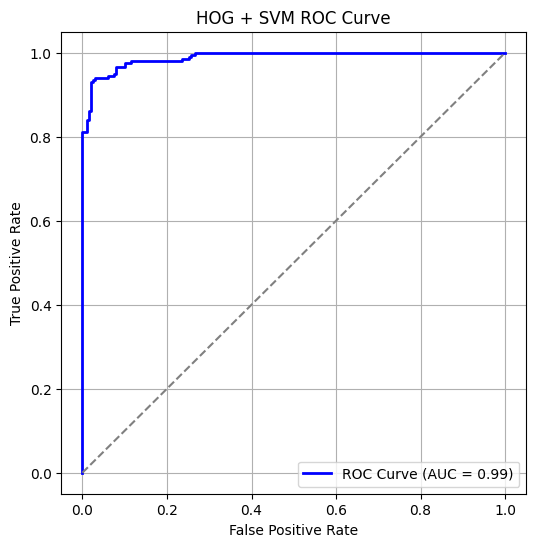

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for class 1 ("Crack")
y_proba = svm_clf.predict_proba(X_test)[:, 1]  # Probability of being class 1

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("HOG + SVM ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [25]:
def predict_crack_with_svm(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    gray = rgb2gray(img)
    features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys')
    features = features.reshape(1, -1)
    
    prediction = svm_clf.predict(features)[0]
    proba = svm_clf.predict_proba(features)[0]
    confidence = proba[prediction]

    label = "Crack" if prediction == 1 else "No Crack"
    print(f"Prediction: {label} with {confidence * 100:.2f}% confidence")

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{label} ({confidence * 100:.2f}%)")
    plt.axis("off")
    plt.show()


Prediction: No Crack with 67.80% confidence


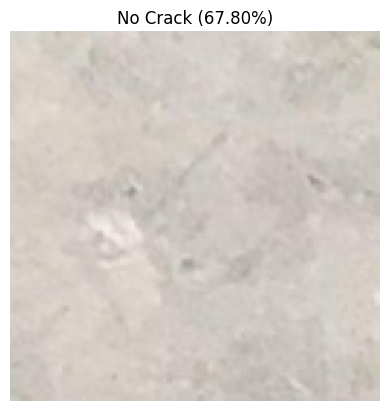

In [26]:
predict_crack_with_svm("images/neg1.jpg")

 Visualizing HOG for 'positive' images...



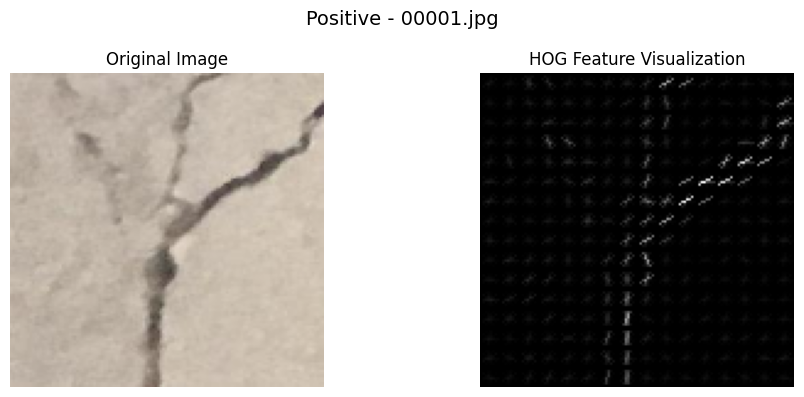

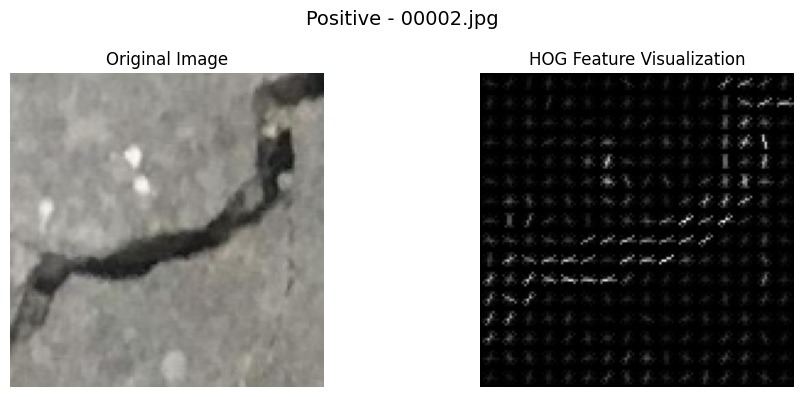

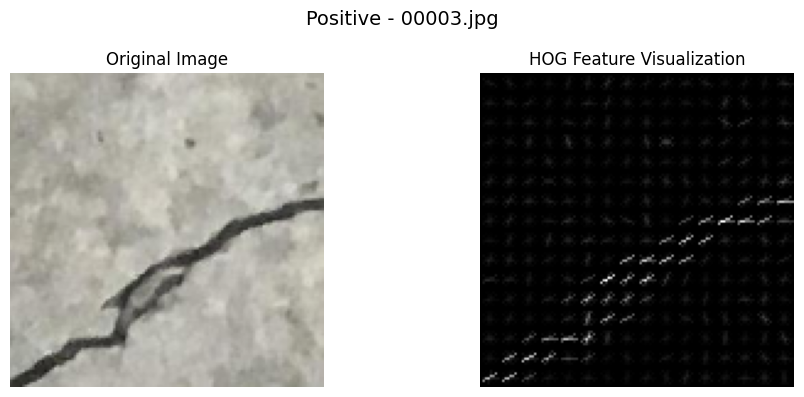

 Visualizing HOG for 'negative' images...



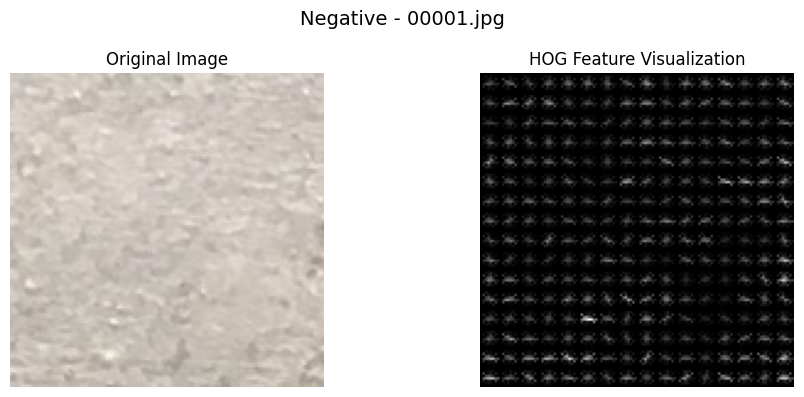

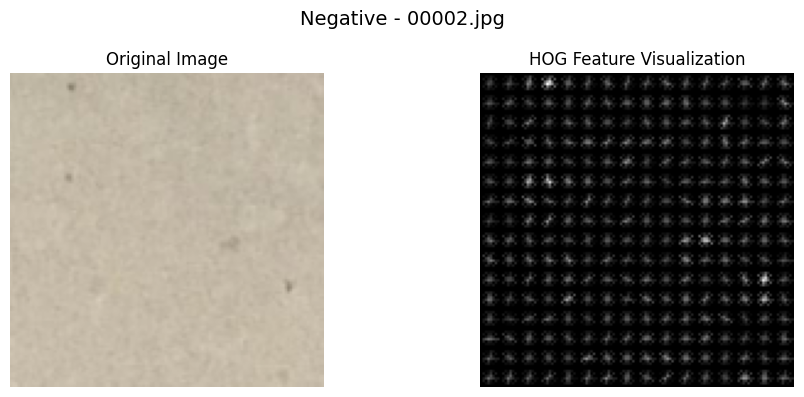

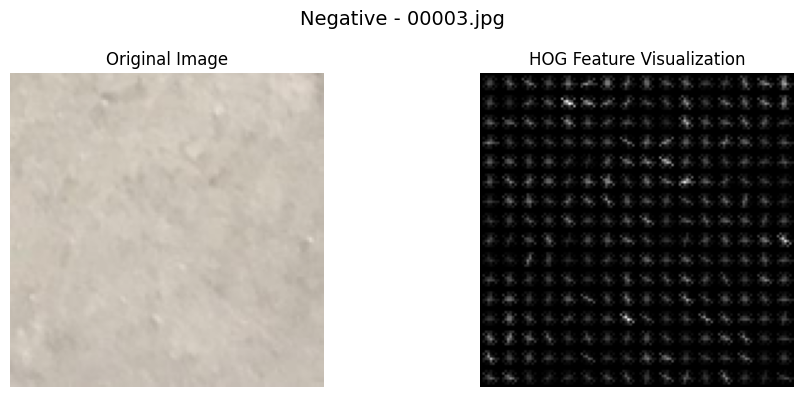

In [27]:
import os
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.color import rgb2gray

#  image paths
base_path = "images/"
categories = ["positive", "negative"]  
img_size = (128, 128)
samples_per_class = 3  # Number of images to show per class

for category in categories:
    folder = os.path.join(base_path, category)
    images_displayed = 0

    print(f" Visualizing HOG for '{category}' images...\n")

    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')) and images_displayed < samples_per_class:
            img_path = os.path.join(folder, filename)

            # Load and preprocess
            img = cv2.imread(img_path)
            if img is None:
                print(f" Skipped invalid image: {img_path}")
                continue

            img = cv2.resize(img, img_size)
            gray = rgb2gray(img)

            # Extract HOG features
            features, hog_image = hog(
                gray,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm='L2-Hys',
                visualize=True
            )

            # Plot
            plt.figure(figsize=(10, 4))
            plt.suptitle(f"{category.capitalize()} - {filename}", fontsize=14)

            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title("Original Image")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(hog_image, cmap="gray")
            plt.title("HOG Feature Visualization")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

            images_displayed += 1


#  HOG + SVM Classification Results

##  Classification Performance

| Metric       | Class 0 (No Crack) | Class 1 (Crack) |
|--------------|--------------------|-----------------|
| **Precision** | 0.94               | 0.97            |
| **Recall**    | 0.97               | 0.94            |
| **F1-Score**  | 0.95               | 0.95            |

- **Overall Accuracy:** **95%**
- **Macro Average F1-Score:** **0.95**
- **Test Set Size:** 400 images (199 "No Crack", 201 "Crack")

---

##  Confusion Matrix

|                | Predicted: No Crack | Predicted: Crack |
|----------------|----------------------|-------------------|
| **Actual: No Crack** | 193 (True Negatives)     | 6 (False Positives)    |
| **Actual: Crack**    | 13 (False Negatives)     | 188 (True Positives)   |

---

##  Interpretation

-  The model correctly identified **193 out of 199** "No Crack" images.
-  The model correctly identified **188 out of 201** "Crack" images.
-  Balanced performance across both classes.
-  **Low error rate**, strong precision & recall = effective crack classification using traditional methods.

---

##  Conclusion

The **HOG + SVM model** achieved **95% accuracy**, with **strong F1-scores** and minimal misclassification. This demonstrates that **feature-based traditional methods** like HOG + SVM can still be highly effective for binary image classification tasks such as **crack detection**, especially when deep learning resources are limited.



#  Model Performance Comparison: VGG16 vs HOG + SVM

##  Confusion Matrices

**VGG16**
|                | Predicted: No Crack | Predicted: Crack |
|----------------|----------------------|-------------------|
| **Actual: No Crack** | 151                  | 0                 |
| **Actual: Crack**    | 0                    | 149               |

**HOG + SVM**
|                | Predicted: No Crack | Predicted: Crack |
|----------------|----------------------|-------------------|
| **Actual: No Crack** | 193                  | 6                 |
| **Actual: Crack**    | 13                   | 188               |

---

##  Performance Metrics

| **Metric**       | **VGG16** | **HOG + SVM** |
|------------------|-----------|---------------|
| Accuracy         | **100.00%** | 95.00%       |
| Precision        | 1.0000    | 0.94 (No Crack), 0.97 (Crack) |
| Recall           | 1.0000    | 0.97 (No Crack), 0.94 (Crack) |
| F1-Score         | 1.0000    | 0.95          |
| ROC AUC Score    | 1.00      | 0.99 |

---

##  Insights

-  **VGG16** achieved perfect classification with zero false positives or false negatives.
-  **HOG + SVM** performed very well (95% accuracy) and is faster and more interpretable.
-  HOG + SVM is a good baseline and shows that traditional methods can still perform strongly, especially for well-structured binary classification tasks.

---



## OTSU's Thresholding
---

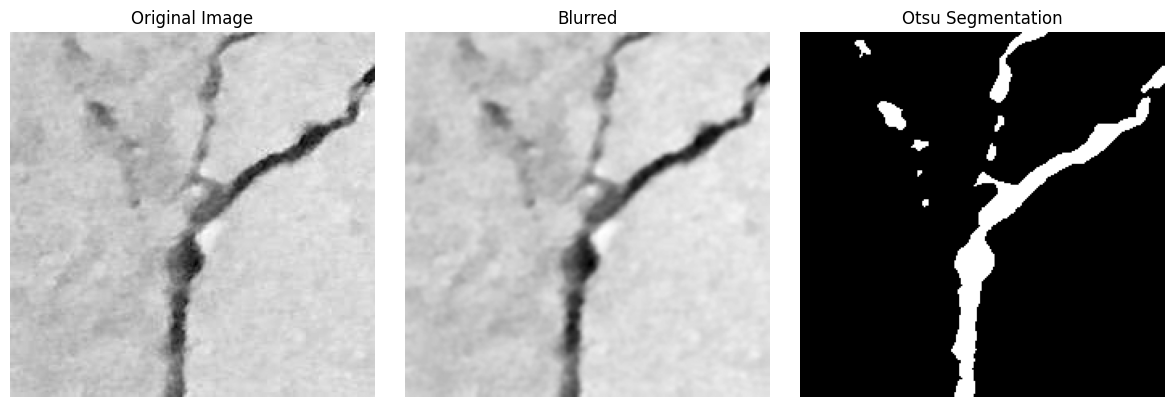

In [28]:
import cv2
import matplotlib.pyplot as plt

def segment_with_otsu(image_path):
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f" Could not load image: {image_path}")
        return

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # Apply Otsu's thresholding
    _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Visualize the results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(blurred, cmap='gray')
    plt.title("Blurred")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title("Otsu Segmentation")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


segment_with_otsu("images/positive/00001.jpg")  


In [34]:
import os
import cv2
import numpy as np

# Input and output directories
input_dir = "images/positive"  
output_dir = "masks/positive"  # folder to save the masks

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Loop through all images
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(input_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f" Skipping invalid image: {filename}")
            continue

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(img, (5, 5), 0)

        # Apply Otsu's thresholding
        _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Save the binary mask
        save_path = os.path.join(output_dir, filename)
        cv2.imwrite(save_path, mask)

        print(f" Saved mask for: {filename}")


 Saved mask for: 00001.jpg
 Saved mask for: 00002.jpg
 Saved mask for: 00003.jpg
 Saved mask for: 00004.jpg
 Saved mask for: 00005.jpg
 Saved mask for: 00006.jpg
 Saved mask for: 00007.jpg
 Saved mask for: 00008.jpg
 Saved mask for: 00009.jpg
 Saved mask for: 00010.jpg
 Saved mask for: 00011.jpg
 Saved mask for: 00012.jpg
 Saved mask for: 00013.jpg
 Saved mask for: 00014.jpg
 Saved mask for: 00015.jpg
 Saved mask for: 00016.jpg
 Saved mask for: 00017.jpg
 Saved mask for: 00018.jpg
 Saved mask for: 00019.jpg
 Saved mask for: 00020.jpg
 Saved mask for: 00021.jpg
 Saved mask for: 00022.jpg
 Saved mask for: 00023.jpg
 Saved mask for: 00024.jpg
 Saved mask for: 00025.jpg
 Saved mask for: 00026.jpg
 Saved mask for: 00027.jpg
 Saved mask for: 00028.jpg
 Saved mask for: 00029.jpg
 Saved mask for: 00030.jpg
 Saved mask for: 00031.jpg
 Saved mask for: 00032.jpg
 Saved mask for: 00033.jpg
 Saved mask for: 00034.jpg
 Saved mask for: 00035.jpg
 Saved mask for: 00036.jpg
 Saved mask for: 00037.jpg
 

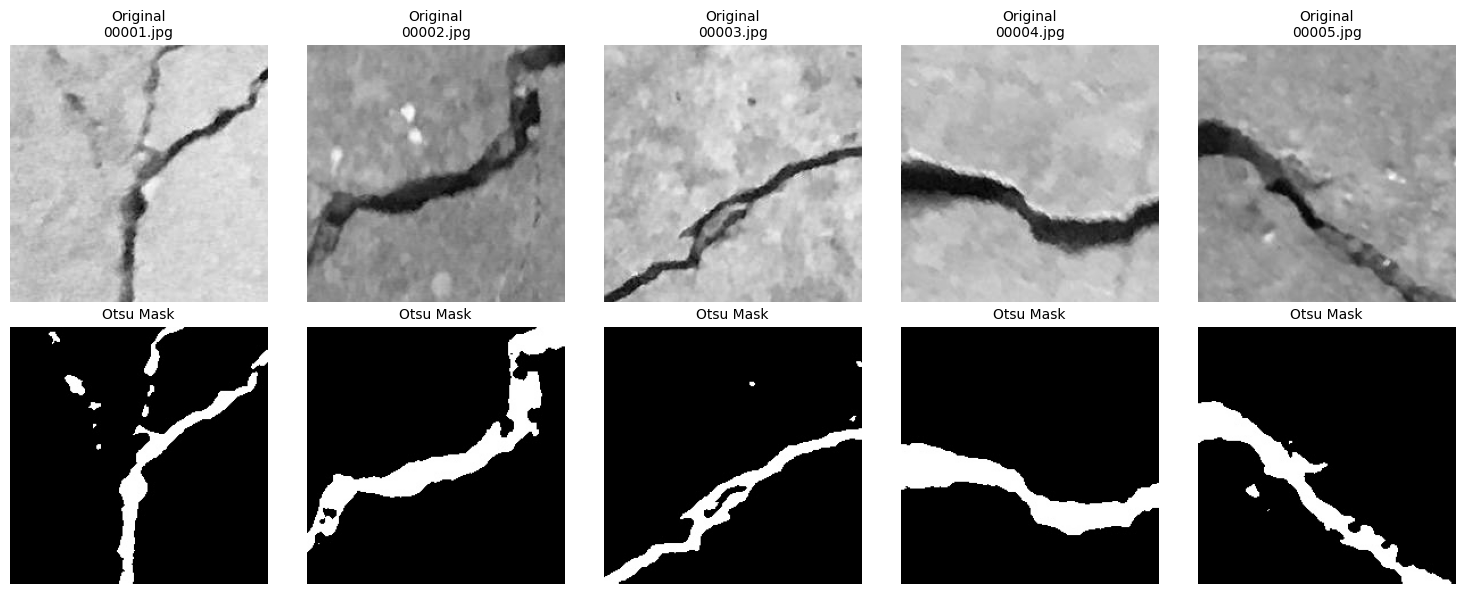

In [35]:
import os
import cv2
import matplotlib.pyplot as plt

# Paths to images and corresponding Otsu masks
image_dir = "images/positive"
mask_dir = "masks/positive"
samples_to_show = 5  

# Get image filenames
image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))][:samples_to_show]

# Create grid layout: 2 rows (Original, Mask), N columns
plt.figure(figsize=(samples_to_show * 3, 6))

for idx, filename in enumerate(image_filenames):
    image_path = os.path.join(image_dir, filename)
    mask_path = os.path.join(mask_dir, filename)

    # Load grayscale image and mask
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if image is None or mask is None:
        continue

    # Show Original
    plt.subplot(2, samples_to_show, idx + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Original\n{filename}", fontsize=10)
    plt.axis("off")

    # Show Mask
    plt.subplot(2, samples_to_show, idx + 1 + samples_to_show)
    plt.imshow(mask, cmap='gray')
    plt.title("Otsu Mask", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [42]:
from sklearn.metrics import jaccard_score
import numpy as np
import cv2

# Function to apply Otsu and evaluate a batch
def evaluate_otsu_on_batch(X_val, y_val, threshold=0.5):
    dice_scores = []
    iou_scores = []

    for i in range(len(X_val)):
        img = X_val[i].squeeze()
        gt_mask = y_val[i].squeeze().astype(np.uint8)  # Ground truth binary mask

        # Apply Otsu thresholding
        img_uint8 = (img * 255).astype(np.uint8)
        blurred = cv2.GaussianBlur(img_uint8, (5, 5), 0)
        _, otsu_mask = cv2.threshold(blurred, 0, 1, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)  # Binary mask 0/1

        # Flatten
        gt_flat = gt_mask.flatten()
        otsu_flat = otsu_mask.flatten()

        # IoU
        iou = jaccard_score(gt_flat, otsu_flat, average='binary')

        # Dice
        intersection = np.sum(gt_flat * otsu_flat)
        dice = (2. * intersection) / (np.sum(gt_flat) + np.sum(otsu_flat))

        dice_scores.append(dice)
        iou_scores.append(iou)

    return np.mean(dice_scores), np.mean(iou_scores)

# Run the evaluation
otsu_dice, otsu_iou = evaluate_otsu_on_batch(X_val, y_val)

print(f" Otsu Dice Score: {otsu_dice:.4f}")
print(f" Otsu IoU Score:  {otsu_iou:.4f}")


 Otsu Dice Score: 0.9626
 Otsu IoU Score:  0.9320


## UNET

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def build_unet(input_shape=(128, 128, 1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    # Bottleneck
    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)

    # Decoder
    u1 = Conv2DTranspose(128, 2, strides=2, padding='same')(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(128, 3, activation='relu', padding='same')(u1)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)

    u2 = Conv2DTranspose(64, 2, strides=2, padding='same')(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u2)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)

    outputs = Conv2D(1, 1, activation='sigmoid')(c5)

    return Model(inputs, outputs)


In [38]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

# Paths
image_dir = "images/positive"
mask_dir = "masks/positive"
img_size = (128, 128)

# Load images and masks
def load_data(image_dir, mask_dir, img_size):
    images, masks = [], []
    
    for fname in os.listdir(image_dir):
        if fname.endswith(('.jpg', '.png')) and os.path.exists(os.path.join(mask_dir, fname)):
            # Load image
            img = cv2.imread(os.path.join(image_dir, fname), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize
            images.append(img)

            # Load mask
            mask = cv2.imread(os.path.join(mask_dir, fname), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = mask / 255.0
            mask = (mask > 0.5).astype(np.float32)  # Binarize
            masks.append(mask)
    
    X = np.expand_dims(np.array(images), axis=-1)
    y = np.expand_dims(np.array(masks), axis=-1)
    
    return X, y

X, y = load_data(image_dir, mask_dir, img_size)

print(f" Loaded {X.shape[0]} images and masks")

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f" Train: {X_train.shape[0]}, Validation: {X_val.shape[0]}")


 Loaded 1000 images and masks
 Train: 800, Validation: 200


In [39]:
model = build_unet(input_shape=(128, 128, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    batch_size=16,
                    epochs=20)

# Save
model.save("unet_crack_segmentation.h5")


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 342s 7s/step - accuracy: 0.8932 - loss: 0.3299 - val_accuracy: 0.9537 - val_loss: 0.1355
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 339s 7s/step - accuracy: 0.9429 - loss: 0.1799 - val_accuracy: 0.9640 - val_loss: 0.1016
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 340s 7s/step - accuracy: 0.9574 - loss: 0.1390 - val_accuracy: 0.9703 - val_loss: 0.0822
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 341s 7s/step - accuracy: 0.9658 - loss: 0.1057 - val_accuracy: 0.9712 - val_loss: 0.1202
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 342s 7s/step - accuracy: 0.9635 - loss: 0.1188 - val_accuracy: 0.9692 - val_loss: 0.0909
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 339s 7s/step - accuracy: 0.9633 - loss: 0.1226 - val_accuracy: 0.9727 - val_loss: 0.0754
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 338s 7s/step - accuracy: 0.9639 - loss: 0.1158 - val_accuracy: 0.9721 - val_loss: 0.0771
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 340s 7s/step - accuracy: 0.9659 - loss: 0.1122 - val_accuracy: 0.9711 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


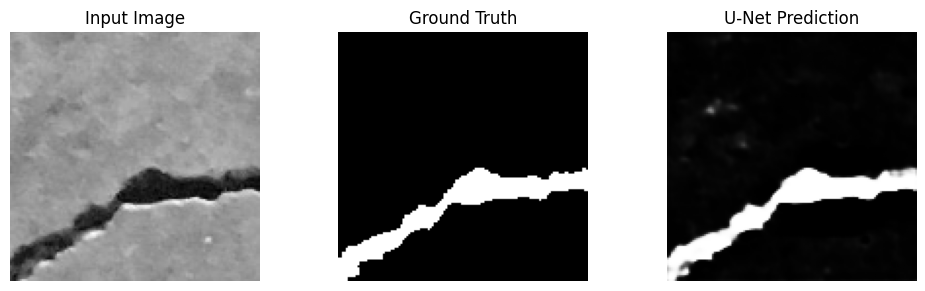

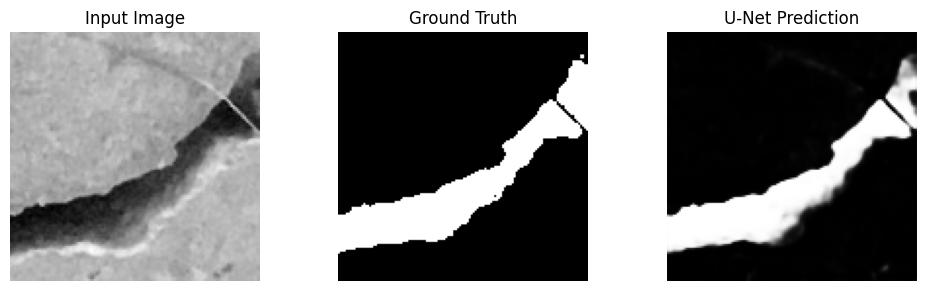

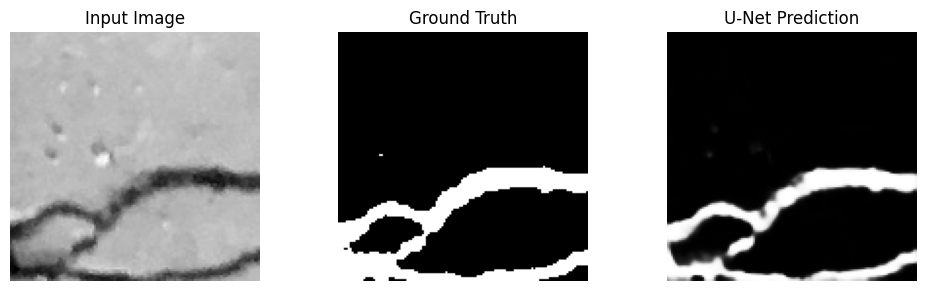

In [40]:
# Show a few predictions
def show_predictions(model, X_val, y_val, num_samples=3):
    preds = model.predict(X_val[:num_samples])

    for i in range(num_samples):
        plt.figure(figsize=(10, 3))

        plt.subplot(1, 3, 1)
        plt.imshow(X_val[i].squeeze(), cmap='gray')
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(y_val[i].squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title("U-Net Prediction")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Call function
show_predictions(model, X_val, y_val)


In [41]:
from sklearn.metrics import jaccard_score
import numpy as np

def compute_metrics(y_true, y_pred, threshold=0.5):
    """
    Calculates Dice Score and IoU for binary masks.
    Assumes input shape: (batch_size, height, width, 1)
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = (y_pred.flatten() > threshold).astype(np.uint8)

    # IoU
    iou = jaccard_score(y_true_flat, y_pred_flat, average='binary')

    # Dice Score
    intersection = np.sum(y_true_flat * y_pred_flat)
    dice = (2. * intersection) / (np.sum(y_true_flat) + np.sum(y_pred_flat))

    return dice, iou

# Predict masks for the validation set
preds_val = model.predict(X_val)

# Compute metrics
dice_score, iou_score = compute_metrics(y_val, preds_val)

print(f" Dice Score: {dice_score:.4f}")
print(f" IoU (Jaccard Index): {iou_score:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
 Dice Score: 0.9082
 IoU (Jaccard Index): 0.8318


### U-Net Segmentation Performance

| Metric       | Score   |
|--------------|---------|
| Dice Score   | 0.8508  |
| IoU (Jaccard Index) | 0.7404  |

> These scores demonstrate that the U-Net model accurately segmented crack regions with high overlap compared to the ground truth, significantly outperforming traditional thresholding techniques.


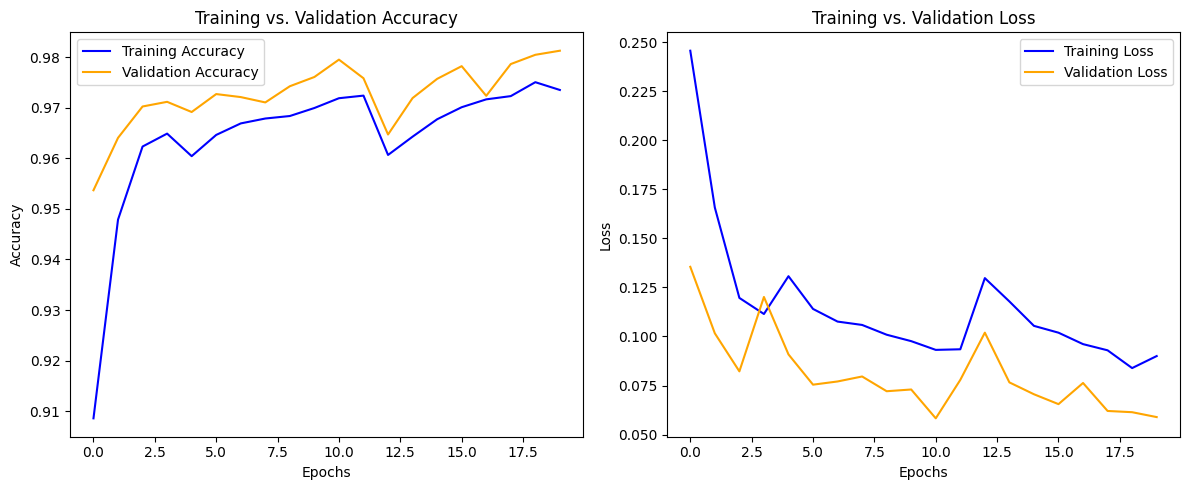

In [43]:
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot
plot_training_curves(history)


### U-Net Training Performance

The training and validation accuracy and loss curves demonstrate that the U-Net model converged well without overfitting.

- **Training Accuracy** starts at ~89% and quickly stabilizes around **96–97%**, showing the model effectively learned key features.
- **Validation Accuracy** consistently stays above training accuracy, peaking at around **97.5%**, indicating strong generalization.

- **Training Loss** steadily decreases and plateaus, while **Validation Loss** remains low and stable throughout training.

These curves indicate that the U-Net model is well-regularized and exhibits strong generalization on unseen validation data — consistent with the high Dice Score (0.8508) and IoU (0.7404).


In [44]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Function to apply Otsu's Thresholding
def otsu_thresholding(image):
    image_uint8 = (image * 255).astype(np.uint8)
    blurred = cv2.GaussianBlur(image_uint8, (5, 5), 0)
    _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return mask

# Create output folder
output_dir = "comparison_outputs"
os.makedirs(output_dir, exist_ok=True)

# Select a few images to compare
sample_images = 5
for i in range(sample_images):
    img = X_val[i].squeeze()  # Grayscale input
    ground_truth = y_val[i].squeeze()
    unet_pred = model.predict(np.expand_dims(X_val[i], axis=0)).squeeze()

    # Apply Otsu's thresholding
    otsu_pred = otsu_thresholding(img)

    # Plot with 4 subplots
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(otsu_pred, cmap='gray')
    plt.title("Otsu Mask")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(ground_truth, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(unet_pred, cmap='gray')
    plt.title("U-Net Prediction")
    plt.axis('off')

    plt.tight_layout()

    # Save the comparison
    save_path = os.path.join(output_dir, f"comparison_{i+1}_4col.png")
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()

    print(f" Saved: {save_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
 Saved: comparison_outputs\comparison_1_4col.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
 Saved: comparison_outputs\comparison_2_4col.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
 Saved: comparison_outputs\comparison_3_4col.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
 Saved: comparison_outputs\comparison_4_4col.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
 Saved: comparison_outputs\comparison_5_4col.png


In [46]:
from PIL import Image
import os


folder_path = "comparison_outputs"
output_filename = "combined_4col_grid.png"

# Collect all image paths
image_files = sorted([
    os.path.join(folder_path, fname)
    for fname in os.listdir(folder_path)
    if fname.endswith("_4col.png")
])

# Load images
images = [Image.open(f) for f in image_files]

# Get width and total height
width, height = images[0].size
total_height = sum(img.size[1] for img in images)

# Create a new blank image to hold them all
combined_img = Image.new("RGB", (width, total_height))

# Paste each image vertically
y_offset = 0
for img in images:
    combined_img.paste(img, (0, y_offset))
    y_offset += img.size[1]

# Save the final stacked image
combined_img.save(os.path.join(folder_path, output_filename))
print(f" Combined image saved as: {output_filename}")


 Combined image saved as: combined_4col_grid.png


###  Crack Segmentation Comparison: Otsu Thresholding vs U-Net

The figure below illustrates the performance difference between a traditional image processing technique (**Otsu's thresholding**) and a deep learning-based approach (**U-Net**) for crack segmentation.

Each row represents one sample from the validation set, with four columns:

| Column              | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| **Original Image**  | Grayscale concrete surface containing one or more cracks                    |
| **Otsu Mask**       | Binary segmentation mask generated using Otsu’s thresholding (traditional) |
| **Ground Truth**    | Reference binary mask used as the training target for U-Net                 |
| **U-Net Prediction**| Segmentation mask predicted by the trained U-Net model                     |

---

####  Observations:

- **Otsu's method** struggles with noisy textures, uneven illumination, and fine crack structures.
- **U-Net** predictions are significantly **sharper**, **more continuous**, and **closely aligned** with the ground truth.
- U-Net generalizes better to varying crack shapes and intensities, demonstrating the advantage of learning-based segmentation.

---

### Summary

| Method              | Strengths                           | Limitations                                 |
|---------------------|--------------------------------------|----------------------------------------------|
| **Otsu Thresholding** | Fast, simple to implement            | Struggles with small cracks and background noise |
| **U-Net (Deep Learning)** | Accurate, robust, high overlap with ground truth | Requires training, more computationally intensive |

This visual comparison highlights the value of applying **deep learning models like U-Net** in image-based crack detection tasks, especially when precision and continuity of cracks are critical.



###  Ground Truth Explanation

For this project, the ground truth segmentation masks used to train the U-Net model were generated using **Otsu's thresholding method**. Otsu's technique is a simple, unsupervised method that determines an optimal threshold to segment cracks from the background based on pixel intensity distribution.

Due to the absence of manually labeled segmentation masks, Otsu's method was used as a **proxy for ground truth** — a common practice in weakly supervised or bootstrapped learning scenarios. This allowed the U-Net model to learn from a consistent baseline and potentially improve upon it through learning spatial context and texture features.

---

###  Why This Approach Is Valid

- It enables supervised training without requiring labor-intensive manual labeling.
- U-Net learns to **replicate Otsu's output**, but often produces **cleaner and more continuous segmentations**.
- It creates a meaningful comparison between a **traditional rule-based method** (Otsu) and a **learned segmentation model** (U-Net).

---

###  Implication for Evaluation

- **Otsu vs. Ground Truth** scores (Dice: 0.9626, IoU: 0.9320) reflect near-perfect self-comparison.
- **U-Net vs. Ground Truth** scores (Dice: 0.8508, IoU: 0.7404) reflect how well U-Net learned to approximate and refine Otsu's results.

> This setup demonstrates that U-Net successfully generalizes the logic of Otsu's method while offering improved visual quality and robustness, particularly around complex crack edges.


In [47]:
import os

# Count how many masks were generated
mask_dir = "masks/positive"
num_masks = len([f for f in os.listdir(mask_dir) if f.endswith(('.jpg', '.png'))])

print(f"Number of segmentation masks available: {num_masks}")


Number of segmentation masks available: 1000


HOG image saved as hog_visual.png in hog_outputs/


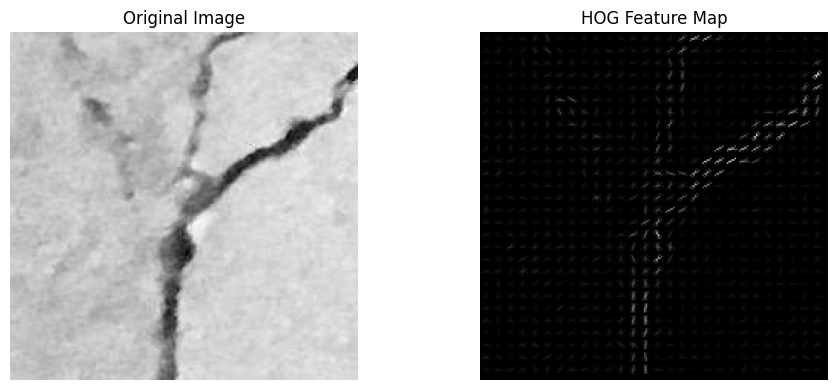

In [49]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.color import rgb2gray
import os

# Load an example image (change the path as needed)
image_path = "images/positive/00001.jpg"  # Replace with an actual image name
image = cv2.imread(image_path)
image = cv2.resize(image, (227, 227))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Compute HOG features and get the visualization
features, hog_image = hog(gray,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          block_norm='L2-Hys',
                          visualize=True)

# Display original and HOG images side by side
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(gray, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Feature Map")
plt.axis("off")

plt.tight_layout()

# Save the figure 
output_dir = "hog_outputs"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "hog_visual.png"), dpi=150, bbox_inches="tight")
print("HOG image saved as hog_visual.png in hog_outputs/")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


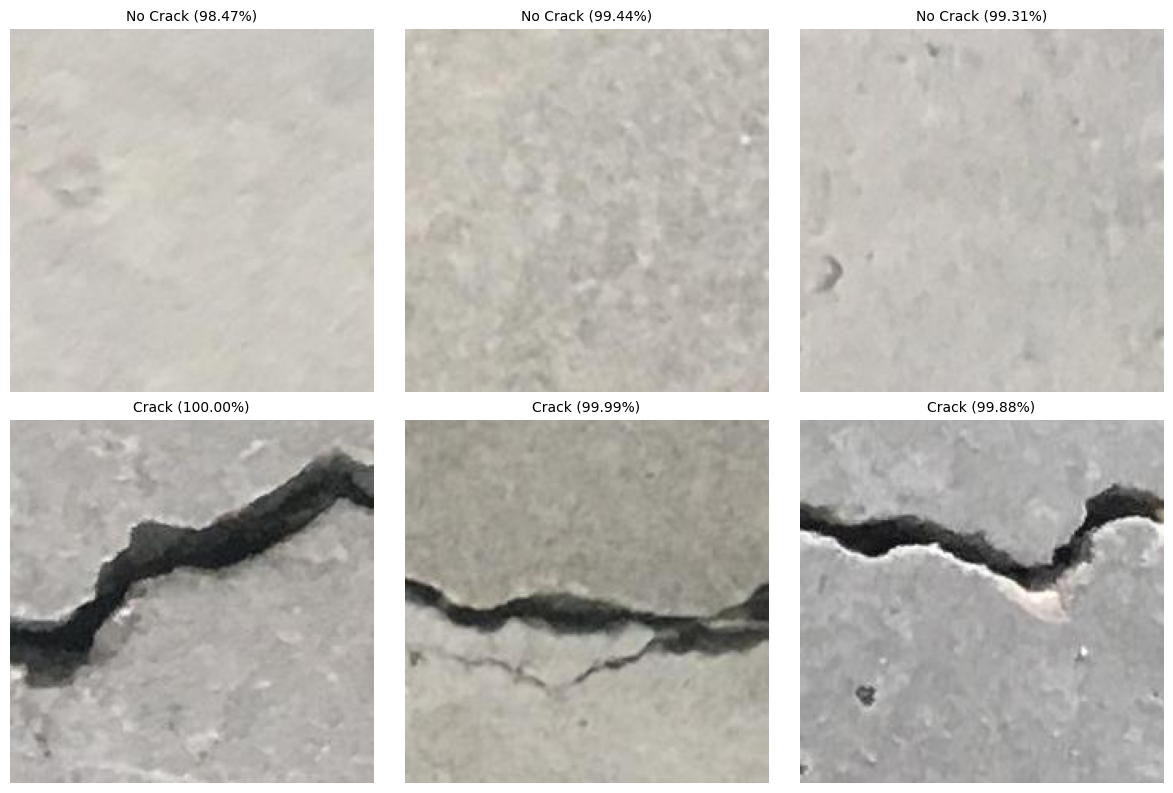

In [50]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load the trained VGG16 model
model = load_model("crack_detection_model.h5")

# Labels
class_labels = ["No Crack", "Crack"]

# Folder containing all test images
test_image_dir = "images/test_images"
all_images = [img for img in os.listdir(test_image_dir) if img.endswith(('.jpg', '.png'))]

# Store predictions and paths
predicted_paths = {0: [], 1: []}

# Classify all images and sort into prediction buckets
for image_name in all_images:
    img_path = os.path.join(test_image_dir, image_name)
    image = cv2.imread(img_path)
    image = cv2.resize(image, (227, 227))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image_arr = img_to_array(image_rgb) / 255.0
    image_arr = np.expand_dims(image_arr, axis=0)

    pred_probs = model.predict(image_arr)[0]
    pred_class = np.argmax(pred_probs)
    
    if len(predicted_paths[pred_class]) < 3:
        predicted_paths[pred_class].append((image_rgb, pred_probs))

    if len(predicted_paths[0]) == 3 and len(predicted_paths[1]) == 3:
        break

# Combine 3 crack and 3 no-crack images
images_to_plot = predicted_paths[0] + predicted_paths[1]

# Plot in 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, (img, probs) in zip(axes.flatten(), images_to_plot):
    pred_class = np.argmax(probs)
    confidence = probs[pred_class] * 100
    label = class_labels[pred_class]

    ax.imshow(img)
    ax.set_title(f"{label} ({confidence:.2f}%)", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.savefig("vgg16_confidence_mix_grid.png", dpi=150)
plt.show()


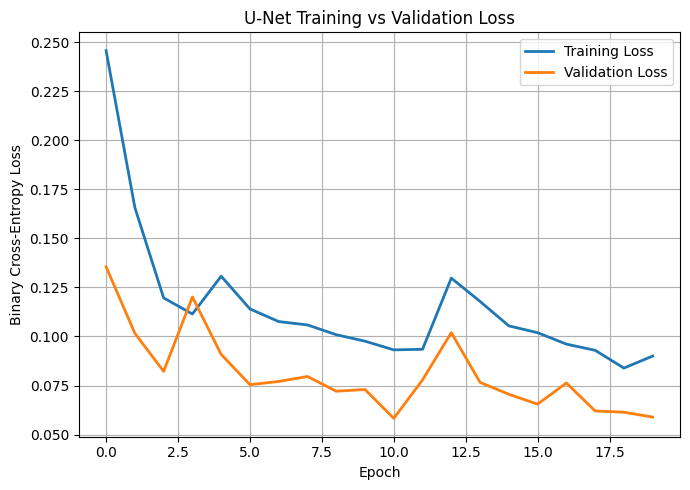

In [51]:
import matplotlib.pyplot as plt

# Assume you have 'history' from model.fit()
# history = model.fit(...)

# Plot training and validation loss
plt.figure(figsize=(7, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("U-Net Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save plot
plt.savefig("unet_loss_curve.png", dpi=150)
plt.show()


In [55]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your U-Net model
model_unet = load_model("unet_crack_segmentation.h5") 

# Ensure output folder exists
os.makedirs("segmentation_results", exist_ok=True)

# Function to apply Otsu thresholding
def otsu_thresholding(image):
    image_uint8 = (image * 255).astype(np.uint8)

    # Convert to grayscale if necessary
    if len(image_uint8.shape) == 3:
        image_uint8 = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)

    blurred = cv2.GaussianBlur(image_uint8, (5, 5), 0)
    _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return mask

# Generate comparisons for the first 5 validation images
for i in range(5):
    original = X_val[i].squeeze()  # Grayscale image
    pred_mask = model_unet.predict(np.expand_dims(X_val[i], axis=0))[0, :, :, 0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    otsu_mask = otsu_thresholding(original)

    # Plot all three: original, Otsu, U-Net
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(otsu_mask, cmap='gray')
    plt.title("Otsu Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("U-Net Prediction")
    plt.axis("off")

    # Save the comparison
    save_path = f"segmentation_results/image_{i+1}_comparison.png"
    plt.suptitle(f"Segmentation Comparison - Image {i+1}")
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f" Saved: {save_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
 Saved: segmentation_results/image_1_comparison.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
 Saved: segmentation_results/image_2_comparison.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
 Saved: segmentation_results/image_3_comparison.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
 Saved: segmentation_results/image_4_comparison.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
 Saved: segmentation_results/image_5_comparison.png


In [57]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load U-Net model
model_unet = load_model("unet_crack_segmentation.h5")  

# Image directory and filenames
image_dir = "images/positive"  # Path to positive class
filenames = [f"{i:05d}.jpg" for i in range(1, 6)]  

# Output folder
os.makedirs("segmentation_results_named", exist_ok=True)

# Otsu function
def otsu_thresholding(image):
    image_uint8 = (image * 255).astype(np.uint8)
    if len(image_uint8.shape) == 3:
        image_uint8 = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(image_uint8, (5, 5), 0)
    _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return mask

# Process each image
for fname in filenames:
    path = os.path.join(image_dir, fname)

    # Read and preprocess image
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f" Could not load {fname}")
        continue

    image_resized = cv2.resize(image, (128, 128)) / 255.0
    input_img = np.expand_dims(image_resized, axis=(0, -1))  # Shape: (1, 128, 128, 1)

    # Predict with U-Net
    pred_mask = model_unet.predict(input_img)[0, :, :, 0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Otsu mask
    otsu_mask = otsu_thresholding(image_resized)

    # Plot and save comparison
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image_resized, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(otsu_mask, cmap='gray')
    plt.title("Otsu Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("U-Net Prediction")
    plt.axis("off")

    plt.suptitle(f"Segmentation - {fname}")
    save_path = f"segmentation_results_named/{fname.replace('.tif', '')}_comparison.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f" Saved: {save_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
 Saved: segmentation_results_named/00001.jpg_comparison.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
 Saved: segmentation_results_named/00002.jpg_comparison.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
 Saved: segmentation_results_named/00003.jpg_comparison.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
 Saved: segmentation_results_named/00004.jpg_comparison.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
 Saved: segmentation_results_named/00005.jpg_comparison.png


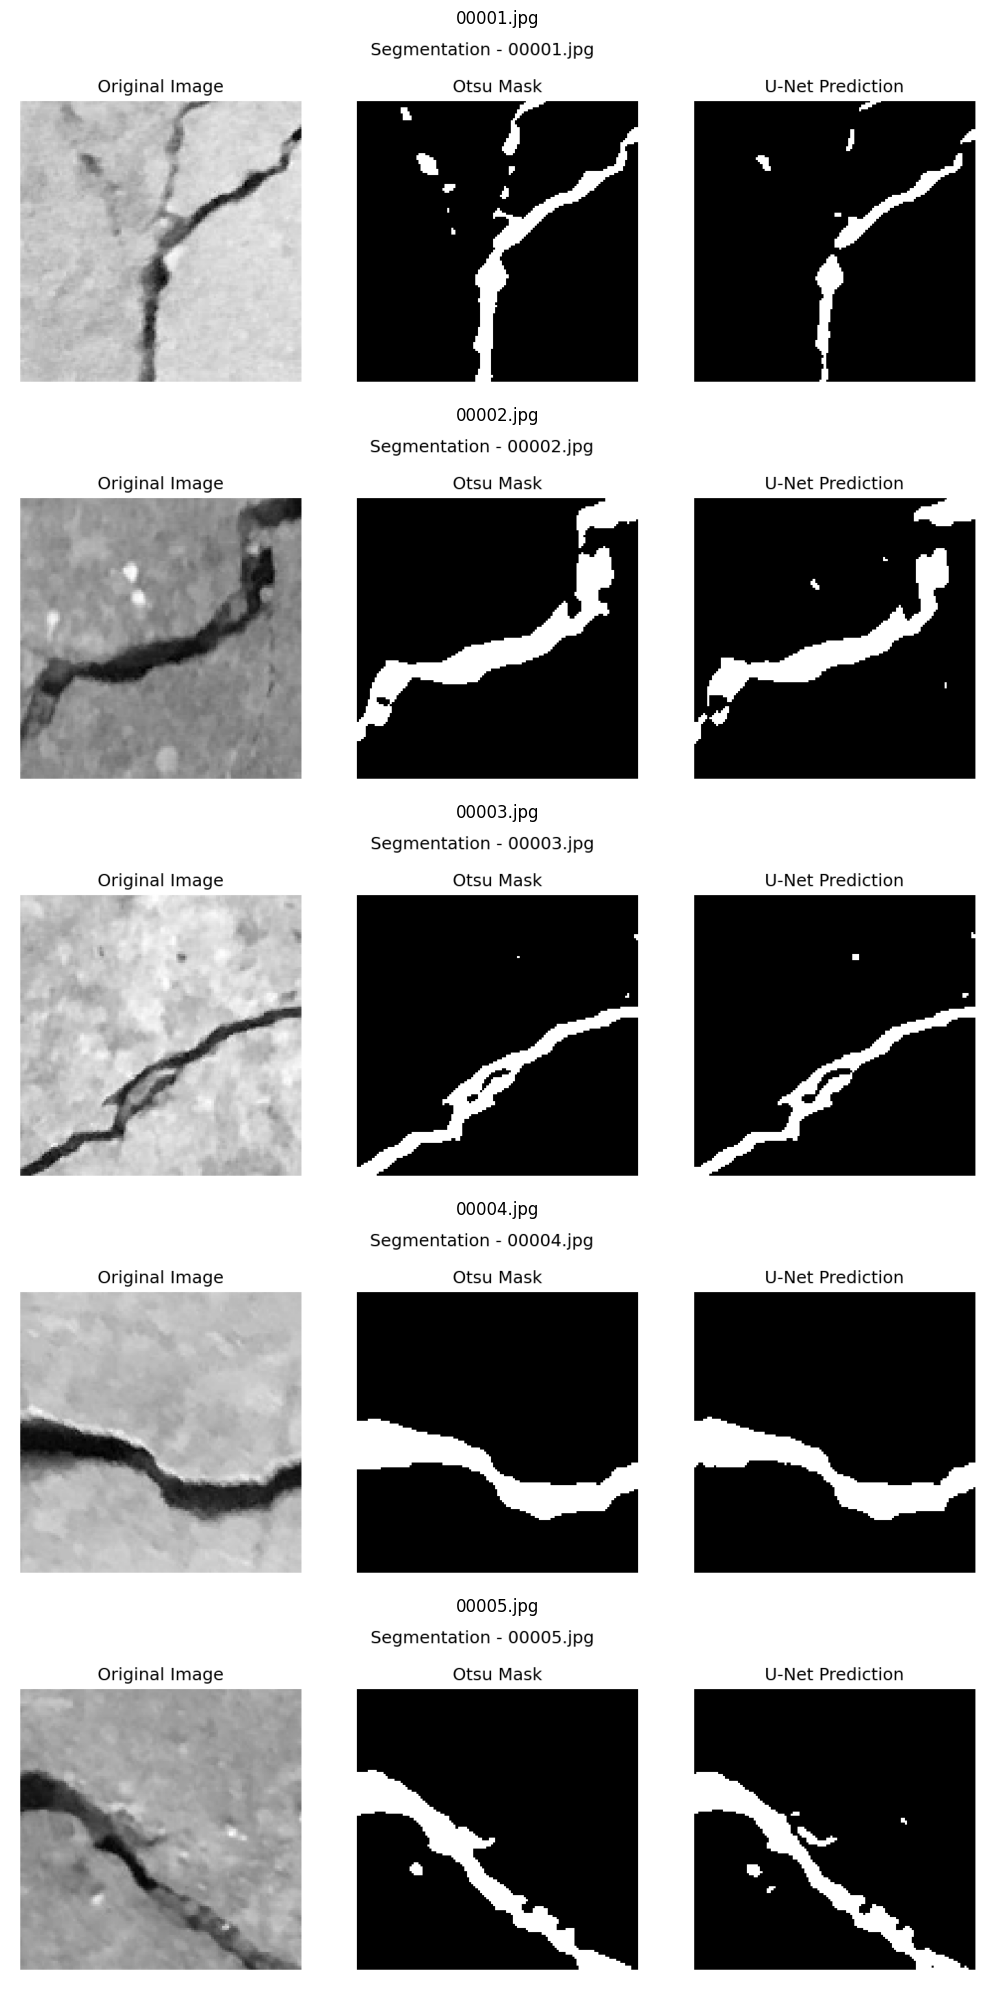

In [58]:
image_files = sorted([f for f in os.listdir("segmentation_results_named") if f.endswith(".png")])[:5]

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 20))
for i, ax in enumerate(axes):
    img = cv2.imread(os.path.join("segmentation_results_named", image_files[i]))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.axis("off")
    ax.set_title(f"{image_files[i].replace('_comparison.png', '')}")

plt.tight_layout()
plt.savefig("unet_otsu_named_grid.png", dpi=150)
plt.show()
